In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# --- IMPORT SHARED UTILS ---
%load_ext autoreload
%autoreload 2
from db_utils import get_engine

# Viz settings (Магія для красивих графіків)
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

# --- DATA EXTRACTION ---
engine = get_engine()

query = """
SELECT 
    c.customer_unique_id,
    MAX(o.order_purchase_timestamp) as last_order_date,
    COUNT(o.order_id) as frequency,
    SUM(p.payment_value) as monetary
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_payments p ON o.order_id = p.order_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_unique_id
"""

rfm = pd.read_sql(query, engine)
rfm['last_order_date'] = pd.to_datetime(rfm['last_order_date'])
rfm.head()

,customer_unique_id,last_order_date,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,196.89


In [2]:
print("🔄 Calculating Scores & Segments...")

# Recency
max_date = rfm['last_order_date'].max()
rfm['recency'] = (max_date - rfm['last_order_date']).dt.days

# R & M Scores
rfm['R'] = pd.qcut(rfm['recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm['M'] = pd.qcut(rfm['monetary'], q=5, labels=[1, 2, 3, 4, 5])

# F Score (Manual)
def get_f_score(x):
    if x == 1: return 1
    elif x == 2: return 3
    else: return 5

rfm['F'] = rfm['frequency'].apply(get_f_score)

# Segmentation Logic
def segment_map(row):
    r, f = row['R'], row['F']
    if r >= 4 and f >= 4: return 'Champions'
    elif r >= 3 and f >= 3: return 'Loyal Customers'
    elif r >= 4 and f == 1: return 'New Customers'
    elif r <= 2 and f >= 3: return 'At Risk'
    elif r == 3 and f == 1: return 'Promising'
    elif r <= 2 and f == 1: return 'Hibernating'
    else: return 'Potential Loyalist'

rfm['Segment'] = rfm.apply(segment_map, axis=1)
rfm.head()

🔄 Calculating Scores & Segments...


,customer_unique_id,last_order_date,frequency,monetary,recency,R,M,F,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,141.90,111,4,4,1,New Customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,27.19,114,4,1,1,New Customers
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22,536,1,2,1,Hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,43.62,320,2,1,1,Hibernating
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,196.89,287,2,4,1,Hibernating


📊 Generating Treemap...


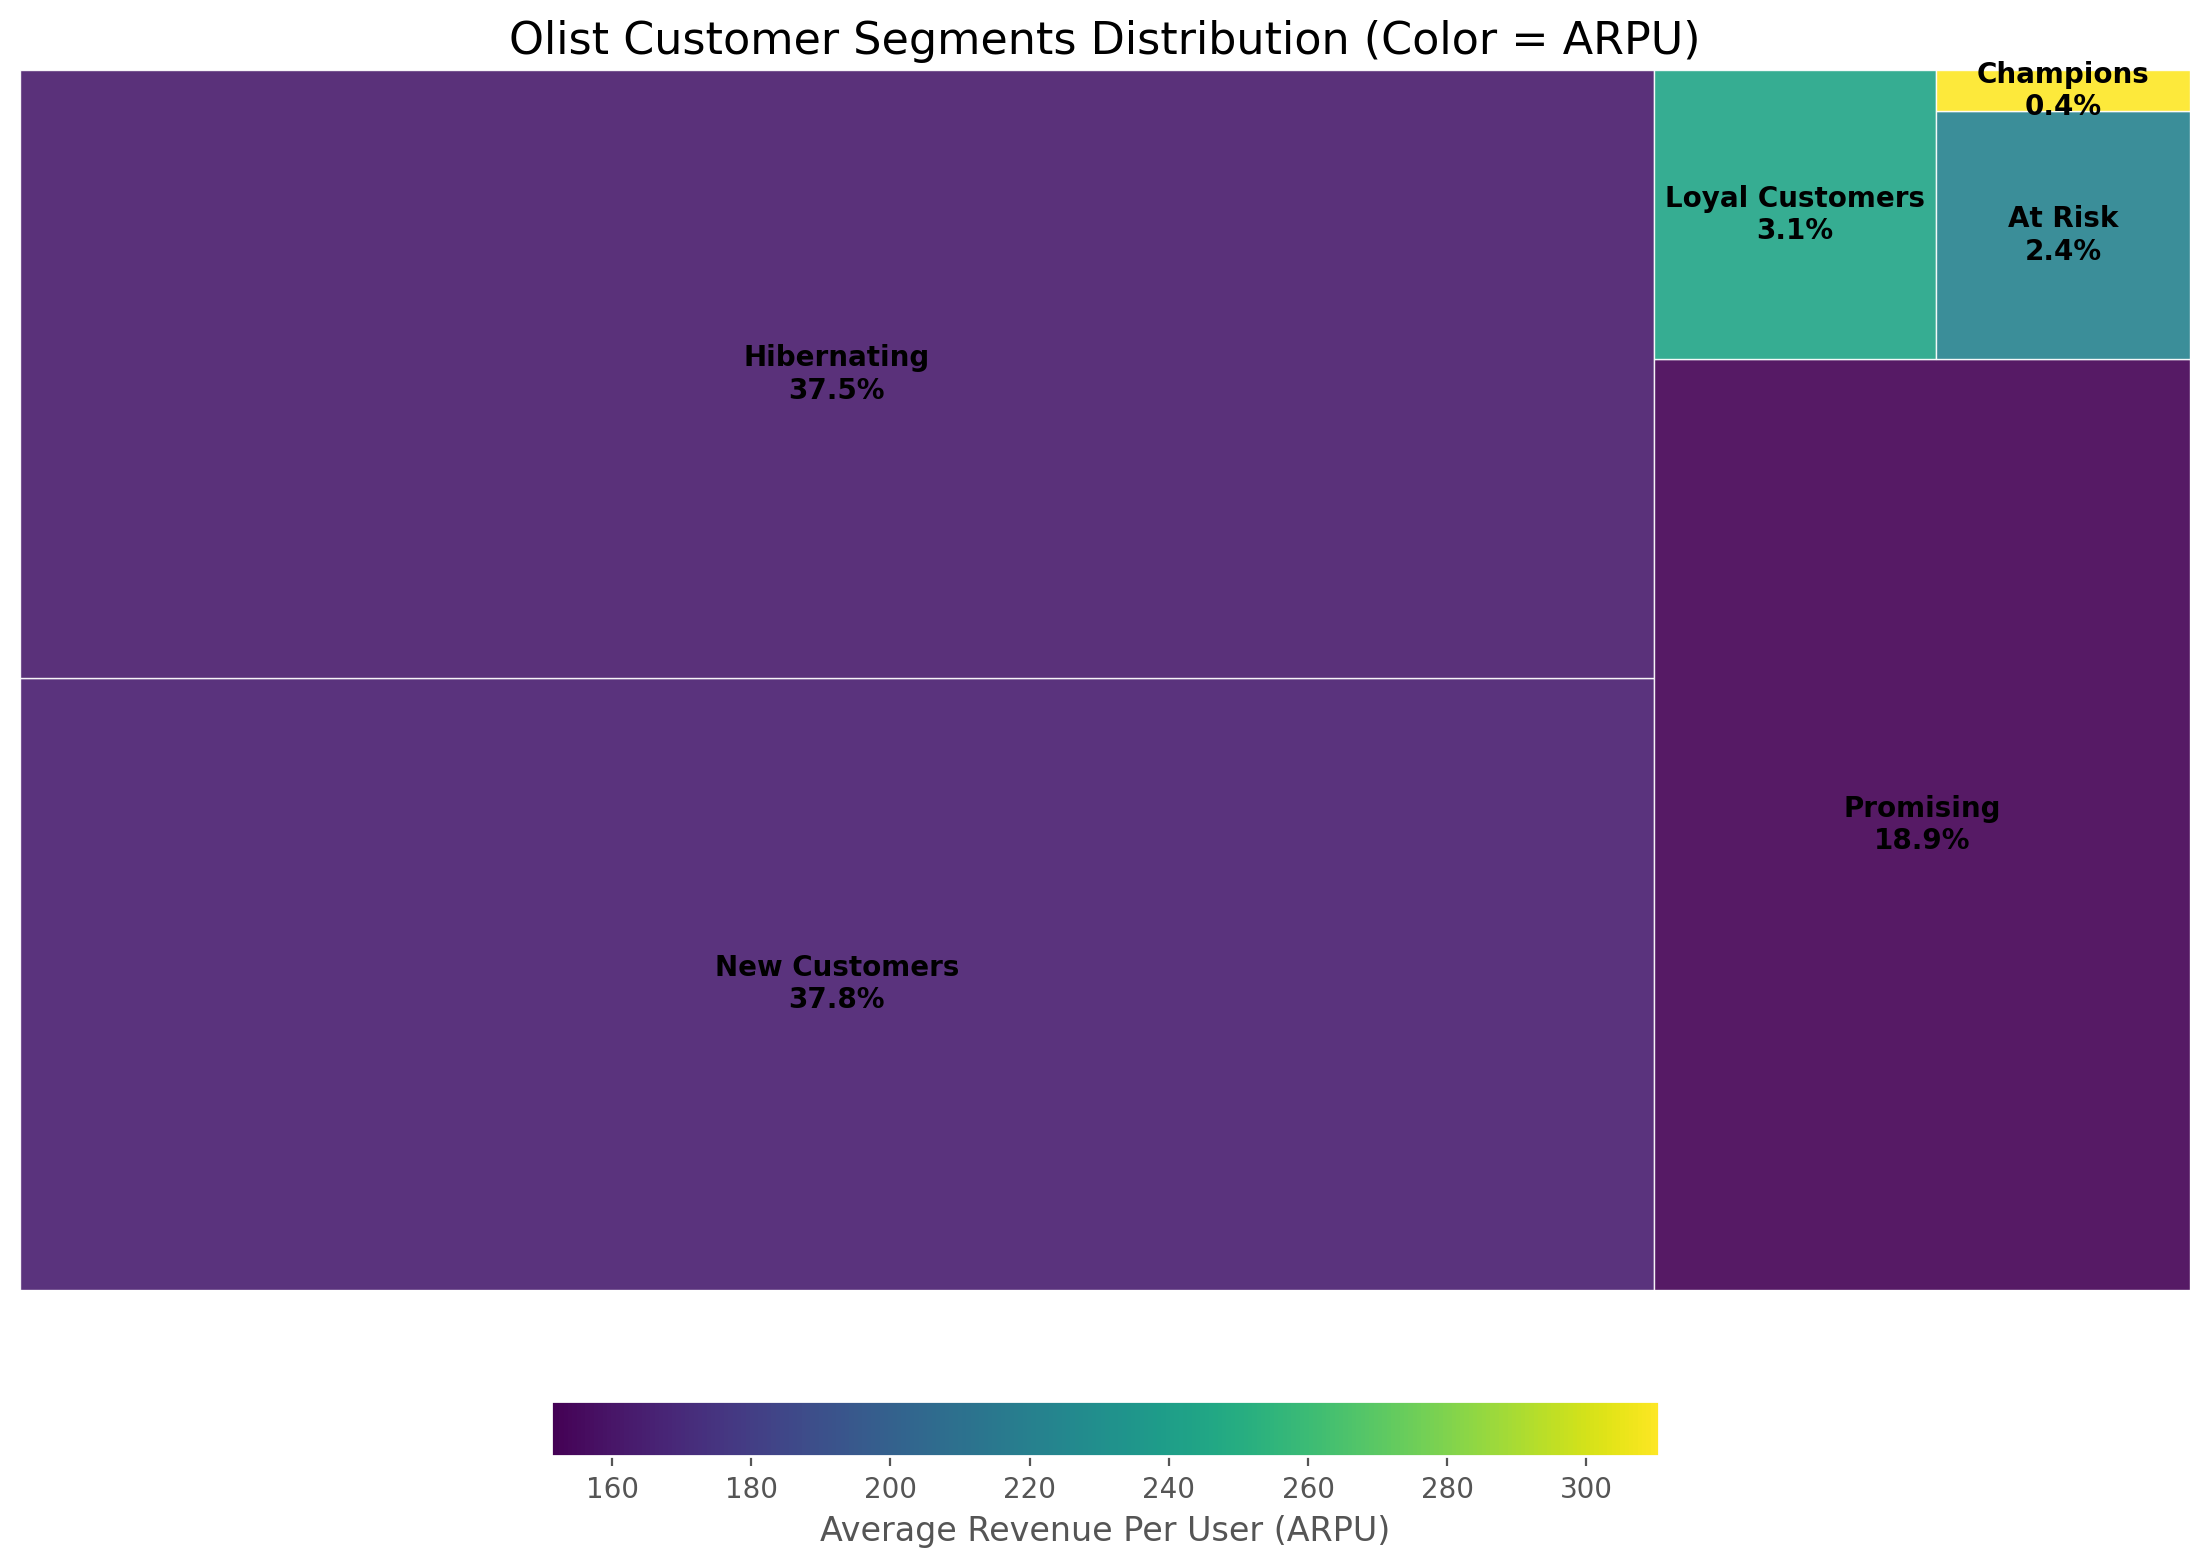

In [3]:
print("📊 Generating Treemap...")

# Aggregation
segment_analysis = rfm.groupby('Segment').agg({
    'customer_unique_id': 'count',
    'monetary': 'sum',
}).rename(columns={'customer_unique_id': 'Count', 'monetary': 'Total Revenue'})

# Shares & ARPU Calculation
segment_analysis['User Share'] = segment_analysis['Count'] / segment_analysis['Count'].sum()
segment_analysis['Revenue Share'] = segment_analysis['Total Revenue'] / segment_analysis['Total Revenue'].sum()
segment_analysis['ARPU'] = segment_analysis['Total Revenue'] / segment_analysis['Count']

plot_df = segment_analysis.sort_values('Count', ascending=False)
arpu_values = plot_df['ARPU'] 

# Creating color list
norm = plt.Normalize(vmin=arpu_values.min(), vmax=arpu_values.max())
cmap_func = plt.colormaps['viridis'] 
colors = [cmap_func(norm(value)) for value in arpu_values]

# Plot Setup
plt.figure(figsize=(14, 9))

label_text = [
    f'{row.name}\n{row["User Share"]:.1%}' 
    for i, row in plot_df.iterrows()
]

# Treemap
squarify.plot(
    sizes=plot_df['Count'], 
    label=label_text, 
    color=colors, 
    alpha=0.9,
    edgecolor='white',
    text_kwargs={'fontsize': 10, 'weight': 'bold'}
)

plt.title('Olist Customer Segments Distribution (Color = ARPU)', fontsize=16)
plt.axis('off')

# Color Bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array(arpu_values.values)

cbar = plt.colorbar(sm, ax=plt.gca(), orientation="horizontal", fraction=0.04, pad=0.08)
cbar.set_label('Average Revenue Per User (ARPU)')

plt.show()

In [4]:
print(">>> SEGMENTATION ANALYSIS COMPLETED SUCCESSFULLY")
print("NOTE: Detailed Strategic Action Plan based on these metrics is available in README.md\n")

# Formatting & Print
summary_cols = ['Count', 'User Share', 'Total Revenue', 'Revenue Share']
final_view = segment_analysis[summary_cols].sort_values('Count', ascending=False)

format_rules = {
    'User Share': '{:.1%}'.format,
    'Revenue Share': '{:.1%}'.format,
    'Total Revenue': '{:,.2f}'.format,
    'Count': '{:.0f}'.format
}

print(final_view.to_string(formatters=format_rules))

>>> SEGMENTATION ANALYSIS COMPLETED SUCCESSFULLY
NOTE: Detailed Strategic Action Plan based on these metrics is available in README.md

                Count User Share Total Revenue Revenue Share
Segment                                                     
New Customers   35286      37.8%  5,789,235.05         37.5%
Hibernating     34996      37.5%  5,662,700.12         36.7%
Promising       17611      18.9%  2,662,103.61         17.3%
Loyal Customers  2880       3.1%    703,881.21          4.6%
At Risk          2219       2.4%    491,216.07          3.2%
Champions         365       0.4%    113,325.71          0.7%
